<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim

In [2]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [3]:
from google.colab import files

In [4]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dog-breed-identification

 99% 686M/691M [00:03<00:00, 197MB/s]
100% 691M/691M [00:03<00:00, 202MB/s]


In [7]:
!unzip dog-breed-identification.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488

Let's use 64 most frequent breeds to simplify the task.

In [8]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = '/content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [9]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(4838, 65) (1210, 65)


<ipython-input-9-0037ea12ab23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1


In [10]:
labels_pivot.head()

breed,id,afghan_hound,african_hunting_dog,airedale,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,...,scottish_deerhound,sealyham_terrier,shih-tzu,siberian_husky,silky_terrier,tibetan_terrier,weimaraner,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00214f311d5d2247d5dfe4fe24b2303d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002211c81b498ef88e1b40b9abf84e1d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00290d3e1fdd27226ba27a8ce248ce85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,003df8b8a8b05244b1d920bb6cf451f9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Custom dataset is going to be useful for our needs.

In [11]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [12]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

BATCH_SIZE = 4

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([4, 3, 224, 224]) torch.Size([4]) tensor([51, 24, 10, 39])


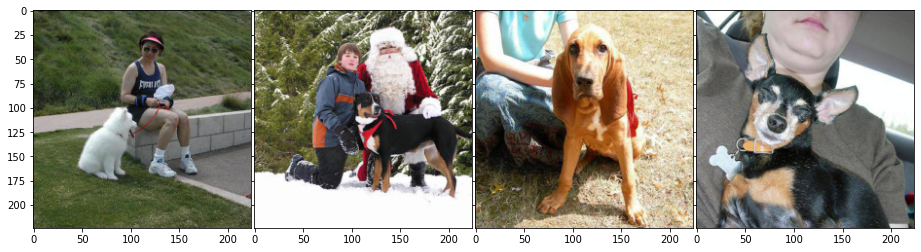

In [15]:
img, label = next(iter(train_dl))
print(img.size(), label.size(), label)
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [ ]:
img.shape

torch.Size([4, 3, 224, 224])

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 1000])

This models provides us with 1000 values, representing the classes which ResNet was trained on. 

Replace last layer with one that predicts the 64 classes. 
The network weights should be fixed expected for the last layer that is trained.

In [ ]:
def train_model(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    for epoch in range(1, num_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss, correct_train = 0.0, 0
        test_loss, correct_test, best_test_acc = 0.0, 0, 0.0
        # model training
        scheduler.step()
        model.train()
        dataset_sizes = {'train': len(dataloders['train'].dataset), 
                         'valid': len(dataloders['valid'].dataset)}

        for batch_idx, (data, target) in enumerate(dataloders['train']):    
            data, target = data.cuda(), target.cuda()      
            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            correct_train += torch.sum(preds == target.data)
            train_epoch_acc = correct_train / len(dataloders['train'].dataset)
            
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))
                print('Epoch: %d \tBatch: %d \tTraining accuracy: %.6f' %(epoch, batch_idx + 1, train_epoch_acc))

        model.eval()
        for batch_idx, (data, target) in enumerate(dataloders['valid']):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target)
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            correct_test += torch.sum(preds == target.data)
            test_epoch_acc = correct_test / len(dataloders['valid'].dataset)
            if test_epoch_acc > best_test_acc:
              best_test_acc = test_epoch_acc
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tBest test accuracy: {:.4f}'.format(
            epoch, 
            train_loss,
            test_loss,
            best_test_acc
            ))  

    return model
  
    # Train the model and evaluate train and test accuracy
    # YOUR CODE
    

In [ ]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 64)

resnet = resnet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [ ]:
model = train_model(dloaders, resnet, criterion, optimizer, scheduler, 3)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Batch: 1 	Training Loss: 4.350545
Epoch: 1 	Batch: 1 	Training accuracy: 0.000000
Epoch: 1 	Batch: 101 	Training Loss: 4.133251
Epoch: 1 	Batch: 101 	Training accuracy: 0.004341
Epoch: 1 	Batch: 201 	Training Loss: 3.899614
Epoch: 1 	Batch: 201 	Training accuracy: 0.015089
Epoch: 1 	Batch: 301 	Training Loss: 3.720852
Epoch: 1 	Batch: 301 	Training accuracy: 0.030798
Epoch: 1 	Batch: 401 	Training Loss: 3.526892
Epoch: 1 	Batch: 401 	Training accuracy: 0.054981
Epoch: 1 	Batch: 501 	Training Loss: 3.351440
Epoch: 1 	Batch: 501 	Training accuracy: 0.083299
Epoch: 1 	Batch: 601 	Training Loss: 3.210926
Epoch: 1 	Batch: 601 	Training accuracy: 0.113270
Epoch: 1 	Batch: 701 	Training Loss: 3.062894
Epoch: 1 	Batch: 701 	Training accuracy: 0.153989
Epoch: 1 	Batch: 801 	Training Loss: 2.942888
Epoch: 1 	Batch: 801 	Training accuracy: 0.192642
Epoch: 1 	Batch: 901 	Training Loss: 2.822979
Epoch: 1 	Batch: 901 	Training accuracy: 0.238115
Epoch: 1 	Batch: 1001 	Training Loss: 2.7143

In [ ]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

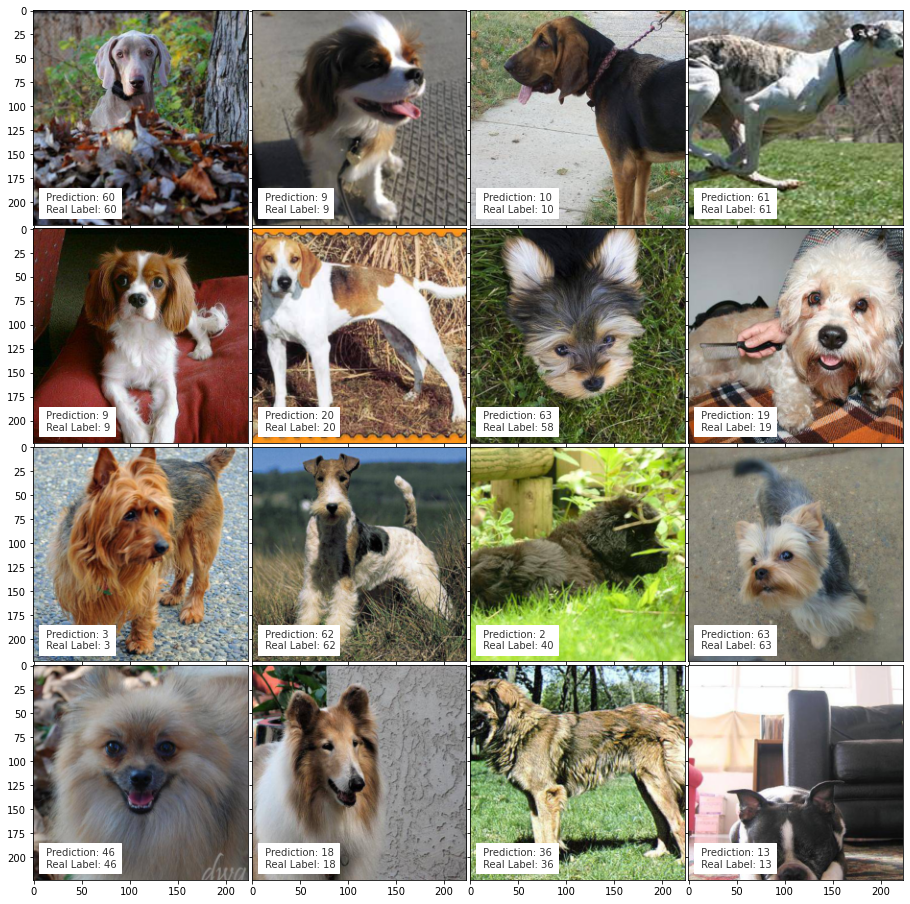

In [ ]:
visualize_model(dloaders, model)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session). 

In [94]:
class CNNAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = x.cuda()
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [95]:
model_cnn = CNNAutoEncoder()
model_cnn = model_cnn.cuda()

Obviously, since the model has not been trained yet, it adds a lot of noise in images.

In [96]:
def train_epoch(net, loader, optimizer, criterion, device): 
    net.train()
    loss_avg = 0
    for x, labels in loader:

        x = x.cuda()

        # zero the gradients
        optimizer.zero_grad()

        # forward propagation
        x_ = net(x)

        #print(z[1:BATCH_SIZE+1].shape)
        #print(z[:BATCH_SIZE].shape)
        #- criterion(z[1:BATCH_SIZE+1], z[:BATCH_SIZE])

        # compute the loss
        loss = criterion(x_, x)

        # backward propagation
        loss.backward()

        # update the weights
        optimizer.step()

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [97]:
def test_epoch(net, loader, criterion, device): 
    net.eval()
    loss_avg = 0
    for x, _ in loader:

        x = x.cuda()

        # forward propagation
        x_ = net(x)

        # compute the loss
        loss = criterion(x_, x)

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [98]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_epoch(net, train_loader, optimizer, criterion, device)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses


In [99]:
lr = 1e-2
weight_decay = 1e-5
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnn = model_cnn.to(device)

optimizer = optim.Adam(model_cnn.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.MSELoss()

In [100]:
train_loss, test_loss = train(model_cnn, train_dl, valid_dl, 
                              optimizer, epochs, criterion, device)

Epoch 1/10: Train loss = 0.7911 - Test loss = 0.7526
Epoch 2/10: Train loss = 0.7721 - Test loss = 0.7447
Epoch 3/10: Train loss = 0.7679 - Test loss = 0.7488
Epoch 4/10: Train loss = 0.7691 - Test loss = 0.7536
Epoch 5/10: Train loss = 0.7660 - Test loss = 0.7684
Epoch 6/10: Train loss = 0.7649 - Test loss = 0.7519
Epoch 7/10: Train loss = 0.7684 - Test loss = 0.7424
Epoch 8/10: Train loss = 0.7672 - Test loss = 0.7420
Epoch 9/10: Train loss = 0.7668 - Test loss = 0.7736
Epoch 10/10: Train loss = 0.7698 - Test loss = 0.7533


In [101]:
import torchvision.utils

In [102]:
def to_img(x):
  x = 0.5 * (x + 1)
  x = x.clamp(0,1)
  return x

def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

def visualize_output(images,model):
  with torch.no_grad():

    images = images.to(device)
    images = model(images)
    images = images.cpu()
    np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1,2,0)))
    plt.show()

Original images:


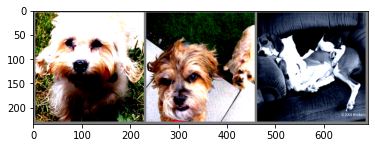

Autoencoded images:


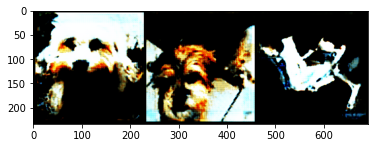

In [103]:
model_cnn.eval()

images, labels = next(iter(train_dl))

print('Original images:')
show_image(torchvision.utils.make_grid(images[1:50], 10, 5))
plt.show()

print('Autoencoded images:')
visualize_output(images, model_cnn)

**Latent Space Interpolation**

In [104]:
# grouping dogs
dogs = [[] for _ in range(10)]
for img_batch, label_batch in valid_dl:
  for i in range(img_batch.size(0)):
    dogs[i].append(img_batch[i:i+1])

  if sum(len(d) for d in dogs) >= 1000:
    break;

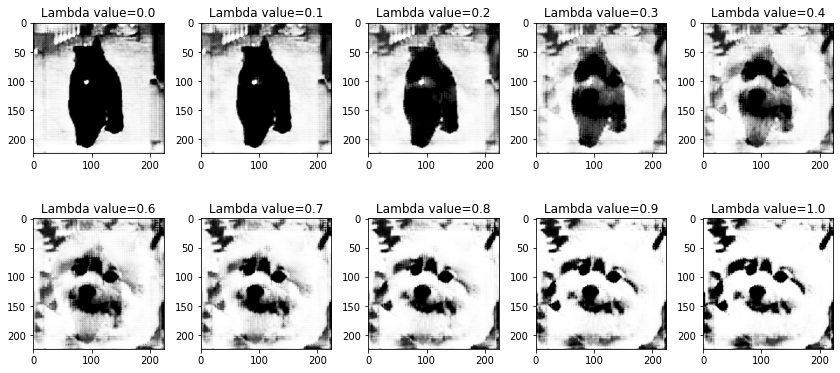

In [105]:
model_cnn.eval()

def interpolation(lambda1, model, img1, img2):
  with torch.no_grad():
    # latent vector of the first image
    img1 = img1.to(device)
    latent_1 = model.encoder(img1)

    #latent vector of the second image
    img2 = img2.to(device)
    latent_2 = model.encoder(img2)

    # interpolation of the two vectors
    inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

    # reconstraction of the interpolated image
    inter_image = model.decoder(inter_latent)
    inter_image = inter_image.cpu()

  return inter_image

lambda_range = np.linspace(0,1,10)

fig, ax = plt.subplots(2, 5, figsize=(15,6))
fig.subplots_adjust(hspace=.5, wspace=0.001)
ax = ax.ravel()

for ind, l in enumerate(lambda_range):
  inter_image = interpolation(float(l), model_cnn, dogs[1][0], dogs[1][1])
  inter_image = to_img(inter_image)
  image = inter_image.numpy()

  ax[ind].imshow(image[0,0,:,:], cmap='gray')
  ax[ind].set_title('Lambda value=' + str(round(l, 1)))

plt.show()
                  

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step. 
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both. 

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnext = models.resnext50_32x4d(pretrained=True)
inputs, labels = next(iter(train_dl))
alex_net = resnext.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnext(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([4, 1000])

In [ ]:
for param in resnext.parameters():
    param.requires_grad = False

in_features_res = resnext.fc.in_features
resnext.fc = nn.Linear(in_features_res, 64)
resnext = resnext.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnext.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [ ]:
model_resnext = train_model(dloaders, resnext, criterion, optimizer, scheduler)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Batch: 1 	Training Loss: 4.206254
Epoch: 1 	Batch: 1 	Training accuracy: 0.000000
Epoch: 1 	Batch: 101 	Training Loss: 4.077616
Epoch: 1 	Batch: 101 	Training accuracy: 0.003927
Epoch: 1 	Batch: 201 	Training Loss: 3.819454
Epoch: 1 	Batch: 201 	Training accuracy: 0.019016
Epoch: 1 	Batch: 301 	Training Loss: 3.595883
Epoch: 1 	Batch: 301 	Training accuracy: 0.039686
Epoch: 1 	Batch: 401 	Training Loss: 3.400755
Epoch: 1 	Batch: 401 	Training accuracy: 0.067177
Epoch: 1 	Batch: 501 	Training Loss: 3.222538
Epoch: 1 	Batch: 501 	Training accuracy: 0.101695
Epoch: 1 	Batch: 601 	Training Loss: 3.060208
Epoch: 1 	Batch: 601 	Training accuracy: 0.142208
Epoch: 1 	Batch: 701 	Training Loss: 2.915780
Epoch: 1 	Batch: 701 	Training accuracy: 0.187061
Epoch: 1 	Batch: 801 	Training Loss: 2.791561
Epoch: 1 	Batch: 801 	Training accuracy: 0.235635
Epoch: 1 	Batch: 901 	Training Loss: 2.683077
Epoch: 1 	Batch: 901 	Training accuracy: 0.285449
Epoch: 1 	Batch: 1001 	Training Loss: 2.5771

In [ ]:
def output_model(dataloders, model1, model2):
    cnt = 0
    output = []
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        #_, preds = torch.max(outputs.data, 1)
        outputs = torch.mean(torch.stack([outputs1, outputs2]), dim=0)
        output.append(outputs)
    return output

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, model1, model2):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.stack_1 = model1
        self.stack_2 = model2
    def forward(self, x):
        logits_1 = self.stack_1(x)
        logits_2 = self.stack_2(x)
        return torch.mean(torch.stack([logits_1, logits_2]), dim=0)

In [ ]:
final_model = NeuralNetwork(model_resnext, model).to(device)

In [ ]:
learning_rate = 1e-3
batch_size = 4
epochs = 5

In [ ]:
result = model_resnext = train_model(dloaders, final_model, criterion, optimizer, scheduler, 3)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 	Batch: 1 	Training Loss: 1.407233
Epoch: 1 	Batch: 1 	Training accuracy: 0.000620
Epoch: 1 	Batch: 101 	Training Loss: 1.105670
Epoch: 1 	Batch: 101 	Training accuracy: 0.067590
Epoch: 1 	Batch: 201 	Training Loss: 1.064502
Epoch: 1 	Batch: 201 	Training accuracy: 0.133940
Epoch: 1 	Batch: 301 	Training Loss: 1.044930
Epoch: 1 	Batch: 301 	Training accuracy: 0.202356
Epoch: 1 	Batch: 401 	Training Loss: 1.050331
Epoch: 1 	Batch: 401 	Training accuracy: 0.268086
Epoch: 1 	Batch: 501 	Training Loss: 1.057880
Epoch: 1 	Batch: 501 	Training accuracy: 0.332782
Epoch: 1 	Batch: 601 	Training Loss: 1.048284
Epoch: 1 	Batch: 601 	Training accuracy: 0.401406
Epoch: 1 	Batch: 701 	Training Loss: 1.043650
Epoch: 1 	Batch: 701 	Training accuracy: 0.467962
Epoch: 1 	Batch: 801 	Training Loss: 1.047127
Epoch: 1 	Batch: 801 	Training accuracy: 0.534312
Epoch: 1 	Batch: 901 	Training Loss: 1.048222
Epoch: 1 	Batch: 901 	Training accuracy: 0.601488
Epoch: 1 	Batch: 1001 	Training Loss: 1.0471

So, the experiments have clearly shown that the new model (the result of stacking two pre-trained models with adjusted last layers) has higher test accuracy, also lower training loss and validation loss have been achieved: The average validation loss has decreased in 35% (0,3464 against 0,5314). Talking about accuracy, the highest achieved value has increased in 5.6%.